# Simplexwise persistent cup length

Our implementation of the persistent cup length algorithm for simplexwise filtrations works with filtrations created with [dionysus](https://www.mrzv.org/software/dionysus/).

In [ ]:
!pip install dionysus
!pip install persim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 6.7 MB/s eta 0:00:00


In [ ]:
import dionysus as d
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math

In [ ]:
from typing import List, Tuple


def cohomology_persistence(f: d._dionysus.Filtration, prime: int = 2) -> Tuple[d._dionysus.CohomologyPersistence, List]:
  p = d.cohomology_persistence(f, prime, True) #The returned object stores the
  #persistence pairs as well as the cocycles still alive at the end of the
  # filtration (i.e., a basis for H^*(K_n))
  dgms = d.init_diagrams(p, f)
  return (p, dgms)

def compute_annotated_barcodes(dgms: List, p: d._dionysus.CohomologyPersistence, k: int) -> Tuple[float, float, d._dionysus.CoChain]:
  """
  Args:
    dgms = persistence diagrams
    p = cohomology persistence
    k = dimension bound
  Returns:
    B_1_k (barcodes annotated by representative cocycles)
  """
  annotated_barcodes = []

  for dim in range(1, k+1):
    for pt in dgms[dim]:
      cocycle = p.cocycle(pt.data)
      annotated_barcodes.append((pt.birth, pt.death, cocycle))

  # sort annotated barcodes first in the increasing order of the death time
  # and then in the increasing order of the birth time
  annotated_barcodes.sort(key=lambda x: x[0])
  annotated_barcodes.sort(key=lambda x: x[1])
  return annotated_barcodes


def compute_coboundary_matrix1(f):
  boundary_matrix = np.zeros((len(f), len(f)))
  for simplex in f:
    if simplex.dimension() >= 1:
      index_of_simplex = f.index(simplex)
      for sb in simplex.boundary():
        index_of_sb = f.index(sb)
        boundary_matrix[index_of_sb, index_of_simplex] = 1

  return np.transpose(boundary_matrix), boundary_matrix

Note that we get $B_{[1,k]}$ directly from cohomology_persistence().

We now define the cup product computation at the cochain level (used on line 15 in Algorithm 2):

In [ ]:
def cup_product(cocycle1: d._dionysus.CoChain, cocycle2: d._dionysus.CoChain, X: List) -> d._dionysus.CoChain:
  """
  Compute the cup product of two cochains over Z_2
  Args:
    cocycle1: first cocycle
    cocycle2: second cocycle
    X: simplicial complex
  """
  size_of_cocycle1 = len(cocycle1)
  size_of_cocycle2 = len(cocycle2)
  p = size_of_cocycle1 + size_of_cocycle2

  # find max dim of simplex in X
  simplicies_dims = [simplex.dimension() for simplex in X]
  dim_X = max(simplicies_dims)

  cocycle1_rep, cocycle2_rep = [], []
  for i in range(2):
    if i == 0:
      cocycle = cocycle1
    else:
      cocycle = cocycle2

    # extract chains that correspond to  cochains in the sum that gives cocycle
    cochain_rep = []

    for cochain in cocycle:
      index_in_reversed = len(X) - 1 - cochain.index
      chain = X[index_in_reversed]
      chain_rep = [chain[i] for i in range(len(chain))]
      cochain_rep.append(chain_rep) # list of lists
    if i == 0:
      cocycle1_rep = tuple(cochain_rep)
    else:
      cocycle2_rep = tuple(cochain_rep)

  # compute the dimension of the cohomology group the cocycle belongs to
  dim_of_cocycle1 = len(cocycle1_rep[0]) - 1
  dim_of_cocycle2 = len(cocycle2_rep[0]) - 1

  sigma_dim = dim_of_cocycle1 + dim_of_cocycle2
  X_p = [simplex for simplex in X if simplex.dimension() == sigma_dim]

  sigma = []
  if dim_of_cocycle1 + dim_of_cocycle2 <= dim_X:
    for i in range(size_of_cocycle1):
      for j in range(size_of_cocycle2):

        a, b = cocycle1_rep[i], cocycle2_rep[j]
        new_a = a.copy()
        if a[-1] == b[0]:
          if len(b[1:]) > 0:
            new_a = new_a + b[1:]
          if d.Simplex(new_a) in X_p:
            sigma.append(new_a)



  return sigma, (cocycle1, cocycle1_rep), (cocycle2, cocycle2_rep)


We define a function to compute a vector representation of a cochain in $S^*$ (used on line 16).

In [ ]:
def vector_rep_of_cochain(sigma: List, S_star: List) -> np.array:
    """
    Compute vector representation y of sigma in S_star, i.e find
    y such that sigma = S_star \dot y where y has 0 or 1 entries.
    """
    y = np.zeros(len(S_star))
    for i in range(len(S_star)):
      if len(sigma) > 0:
        for cochain in sigma:
          if cochain == list(S_star[i]):
            y[i] = 1
    return y


Below is the main code for solving the coboundary condition problem (lines 19 and 22 in the algorithm):

In [ ]:
def contains_nonzero(arr):
    return np.any(arr != 0)

def gf2_gaussian_elimination(A, b):
    # Combine A and b into an augmented matrix
    M = np.column_stack((A, b))
    m, n = M.shape

    # Forward elimination
    for i in range(min(m, n - 1)):
        # Find pivot
        pivot_row = i
        for j in range(i + 1, m):
            if M[j, i] == 1:
                pivot_row = j
                break

        # Swap rows if necessary
        if pivot_row != i:
            M[i], M[pivot_row] = M[pivot_row].copy(), M[i].copy()

        # Eliminate below
        for j in range(i + 1, m):
            if M[j, i] == 1:
                M[j] = np.logical_xor(M[j], M[i]).astype(int)

    # Back substitution
    x = np.zeros(n - 1, dtype=int)
    for i in range(m - 1, -1, -1):
        if M[i, i] == 1:
            x[i] = M[i, -1]
            for j in range(i + 1, n - 1):
                x[i] ^= (M[i, j] & x[j])
        elif np.any(M[i, i+1:-1]) or M[i, -1] == 1:
            return False, None  # No solution

    # Check if solution is valid
    if np.array_equal(np.dot(A, x) % 2, b):
        return True, x
    else:
        return False, None

def has_binary_solution(A, b):
    # Check if A and b contain only 0 and 1
    if not np.all(np.logical_or(A == 0, A == 1)) or not np.all(np.logical_or(b == 0, b == 1)):
        raise ValueError("A and b must contain only 0 and 1")

    return gf2_gaussian_elimination(A, b)


def convert_to_int_if_not_inf(number):
    if not math.isinf(number):
        return int(number)
    return number

Finally, we are ready to implement our persistent cup length algorithm for simplexwise filtrations:

In [ ]:
def compute_persistent_cup_length_2(k: int, S_star: List[d._dionysus.Simplex], R: np.array, B_1_k: List[Tuple[float, float, d._dionysus.CoChain]]) -> Tuple[np.array, List[int], List[int]]:

  """
  Args:
    k: dimension bound
    S_star: the ordered list of cosimplices from dimension 1 to k+1
    R: coboundary matrix R from dimension 0 to k
    B_1_k: barcodes (b_sigma, d_sigma, sigma) annotated by representative
    cocycles, from dimension 1 to k.  (sigma_1,...,sigma_q1) is ordered first
    in the increasing order of the death time and then in the increasing order
    of the birth time.
  Return: a matrix representation of the persistent cup-length-diagram, and
  the lists of distinct birth times b_time and death times d_time
  """

  counter = 0
  #B_1_k looks like [(pt1, cocycle1), (pt2, cocycle2)]
  b_time = list(np.arange(len(S_star)))
  d_time = list(np.arange(len(S_star)))
  d_time.append(math.inf)

  #positive_dim_simplices = [simplex for simplex in S_star if simplex.dimension() > 0]
  m_k, l, B_1 = len(S_star), 1, B_1_k # m_k is the number of simplices with positive dimension in the (k + 1)-skeleton Xk+1 of X
  A_0 = np.zeros((len(b_time), len(d_time)))
  A_1 = np.zeros((len(b_time), len(d_time)))
  A = [A_0, A_1]
  R = R.astype(int)

  B = [[], B_1]

  b_d_times = [(convert_to_int_if_not_inf(elt[0]), convert_to_int_if_not_inf(elt[1])) for elt in B_1]

  for i in range(len(b_time)):
    for j in range(len(d_time)):
      if (b_time[i], d_time[j]) in b_d_times:

        A_1[i,j] = 1
  A[1] = A_1

  while ((not np.array_equal(A[l-1], A[l])) and (l <= k-1)):
    A.append(A_1.copy())

    B_l_plus_1 = []
    B.append(B_l_plus_1)
    for barcode_1 in B[1]:
      for barcode_2 in B[l]:
        sigma, sigma1, sigma2 = cup_product(barcode_1[2], barcode_2[2], S_star)

        y = vector_rep_of_cochain(sigma, S_star).astype(int)[::-1]

        if contains_nonzero(y):

          if not math.isinf(min(barcode_1[1], barcode_2[1])):
            d_min = int(min(barcode_1[1], barcode_2[1]))
          else:
            d_min = len(S_star)+1
          if (has_binary_solution(R[:d_min, :d_min], y[:d_min])[0] == False):

            i_primes = [i for i in range(len(b_time)) if b_time[i] <= min(barcode_1[1], barcode_2[1])]
            i = max(i_primes)

            s_i = 0 # number of simplices alive at b_i (line 13)
            for simplex in S_star:
              if simplex.data <= b_time[i]:
                s_i += 1


            while (has_binary_solution(R[:s_i, :s_i], y[:s_i])[0] == False):

                if i == 0:
                  break

                i = i-1

                s_i = 0
                for simplex in S_star:
                    if simplex.data <= b_time[i]:
                      s_i += 1

                if contains_nonzero(y[:s_i]) == False:
                  break


            if (b_time[i] < min(barcode_1[1], barcode_2[1])):
                B[l+1].append((b_time[i],  min(barcode_1[1], barcode_2[1]), sigma))
                j1, j2 = d_time.index(convert_to_int_if_not_inf(barcode_1[1])), convert_to_int_if_not_inf(d_time.index(barcode_2[1]))
                A[l+1][i, min(j1, j2)] = l + 1

    l = l+1
  return (A[l], b_time, d_time)

# Custom torus filtration (54 filtration times)

We now test our algorithm on a custom filtration of the torus with 52 simplices added one at a time. Here is a visualization of the filtration: https://drive.google.com/file/d/1lhwYBBIXPZPgjOPl6H9wTvv_B2ww5jJa/view?usp=sharing

We output the persistent cup-length matrix:

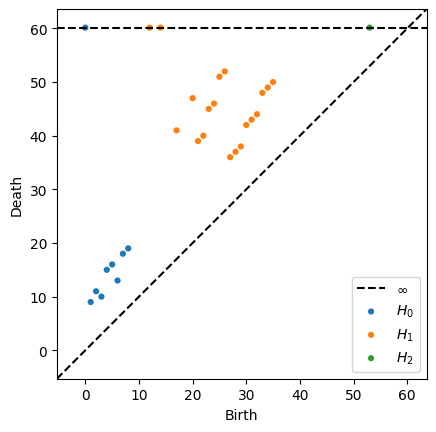

In [ ]:
from persim import plot_diagrams


simplices = [([1], 1), ([2], 2), ([3], 3),([4], 4),   ([5], 5), ([6], 6), ([7], 7), ([8], 8), ([9], 9),
             ([1,2], 10), ([1,4], 11), ([2, 3], 12), ([1, 3], 13),  ([4, 7], 14), ([1, 7], 15), ([4, 5], 16),
             ([5, 6], 17), ([4, 6], 18), ([7, 8], 19), ([8, 9], 20), ([7, 9], 21), ([2, 5], 22), ([3, 6], 23),
             ([5, 8], 24), ([6, 9], 25), ([2, 8], 26), ([3, 9], 27), ([2,4], 28), ([3, 5], 29), ([1, 6], 30),
             ([5, 7], 31), ([6, 8], 32), ([4, 9], 33), ([1, 8], 34), ([2,9], 35), ([3,7], 36), ([1,2,4], 37), ([2,3,5], 38),
             ([1,3,6], 39), ([2,4,5], 40), ([3,5,6], 41), ([1,4,6], 42), ([4,5,7], 43), ([5,6,8], 44), ([4,6,9], 45),
             ([5,7,8], 46), ([6,8,9], 47), ([4,7,9], 48), ([1,7,8], 49), ([2,8,9], 50), ([3,7,9], 51), ([1,2,8], 52), ([2,3,9], 53), ([1,3,7], 54)]
simplices = [(t[0], t[1] - 1) for t in simplices]

k = 1 #dimension bound

# create filtration truncated at k+1
f = d.Filtration()
for vertices, time in simplices:
  if d.Simplex(vertices, time).dimension() <= k+1:
    f.append(d.Simplex(vertices, time))
f.sort()

t = d.homology_persistence(f)

diagrams = d.init_diagrams(t, f)

# Convert Dionysus diagrams to numpy arrays for persim
persim_diagrams = []
for diagram in diagrams:
    points = [[pt.birth, pt.death] for pt in diagram]
    persim_diagrams.append(np.array(points))

# Plot the persistence diagrams using persim
plot_diagrams(persim_diagrams, show=True)
my_torus_filtration = f

In [ ]:
#compute annotated barcodes
k=2

p, dgms = cohomology_persistence(my_torus_filtration)
annotated_barcodes = compute_annotated_barcodes(dgms, p, k)

#compute coboundary matrix
coboundary_matrix, boundary_matrix = compute_coboundary_matrix1(my_torus_filtration) # coboundary matrix from dimension 0 to k

# Create S^*
S_star = list(my_torus_filtration)
S_star.reverse()

#(persistent_cup_length_matrix, A_1, b_times, d_times) = compute_persistent_cup_length(k, S_star, R, annotated_barcodes)
(persistent_cup_length_matrix, b_times, d_times) = compute_persistent_cup_length_2(k, S_star, coboundary_matrix, annotated_barcodes)
print('Persistent cup-length matrix: ', persistent_cup_length_matrix)

Persistent cup-length matrix:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 1.]]


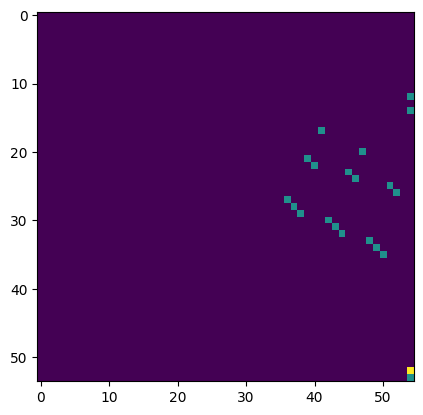

In [ ]:
plt.imshow(persistent_cup_length_matrix)

# Custom torus filtration (3 filtration times)

We now use the same torus filtration as above but with filtration values 0, 1, and 2. We compute the persistent cup-length matrix and output a matrix that represents the cup-length function:

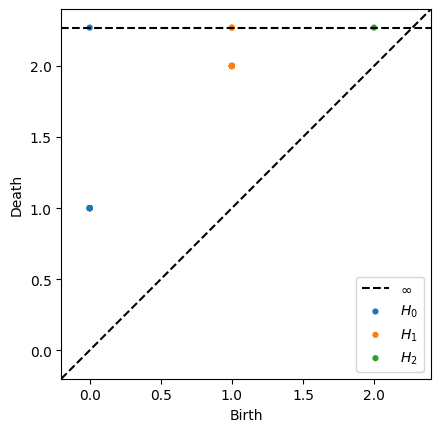

In [ ]:
from persim import plot_diagrams


simplices = [([1], 0), ([2], 0), ([3], 0),([4], 0),   ([5], 0), ([6], 0), ([7], 0), ([8], 0), ([9], 0),
             ([1,2], 1), ([1,4], 1), ([2, 3], 1), ([1, 3], 1),  ([4, 7], 1), ([1, 7], 1), ([4, 5], 1),
             ([5, 6], 1), ([4, 6], 1), ([7, 8], 1), ([8, 9], 1), ([7, 9], 1), ([2, 5], 1), ([3, 6], 1),
             ([5, 8], 1), ([6, 9], 1), ([2, 8], 1), ([3, 9], 1), ([2,4], 1), ([3, 5], 1), ([1, 6], 1),
             ([5, 7], 1), ([6, 8], 1), ([4, 9], 1), ([1, 8], 1), ([2,9], 1), ([3,7], 1), ([1,2,4], 2), ([2,3,5], 2),
             ([1,3,6], 2), ([2,4,5], 2), ([3,5,6], 2), ([1,4,6], 2), ([4,5,7], 2), ([5,6,8], 2), ([4,6,9], 2),
             ([5,7,8], 2), ([6,8,9], 2), ([4,7,9], 2), ([1,7,8], 2), ([2,8,9], 2), ([3,7,9], 2), ([1,2,8], 2), ([2,3,9], 2), ([1,3,7], 2)]

k = 1 #dimension bound

# create filtration truncated at k+1
f = d.Filtration()
for vertices, time in simplices:
  if d.Simplex(vertices, time).dimension() <= k+1:
    f.append(d.Simplex(vertices, time))
f.sort()

t = d.homology_persistence(f)

dgms = d.init_diagrams(t, f)


# Convert Dionysus diagrams to numpy arrays for persim
persim_diagrams = []
for diagram in dgms:
    points = [[pt.birth, pt.death] for pt in diagram]
    persim_diagrams.append(np.array(points))

# Plot the persistence diagrams using persim
plot_diagrams(persim_diagrams, show=True)
my_torus_filtration = f

Below are some helper functions to obtain the persistent cup-length function from the persistent cup-length matrix:

In [ ]:
def create_simplexwise_filtration(f):
  new_filtration = d.Filtration()
  for simplex in f:
    vertices = list(simplex)
    new_filtration.append(d.Simplex(vertices, f.index(simplex)))

  new_filtration.sort()
  return new_filtration

def convert_indices_to_filtration_times(indices: List, original_filtration: d._dionysus.Filtration) -> List:
  """
  takes in indices of simplices in a filtration and returns its filtration values"""
  filtration_values = []
  for index in indices:
    simplex = original_filtration[index]
    filtration_values.append(simplex.data)
  return list(set(filtration_values))


def convert_filtration_time_to_indices(filtration_time: float, original_filtration: d._dionysus.Filtration) -> List:
  """
  takes in filtration time and returns indices of simplices that have that filtration time
  if filtration time is inf, return len(original_filtration), i.e. we added an extra index for inf
  """
  indices = []
  if filtration_time != math.inf:
    for simplex in original_filtration:
      if simplex.data == filtration_time:
        indices.append(f.index(simplex))
  else:
    return [len(original_filtration)]
  return indices

def shrink_cup_length_matrix(persistent_cup_length_matrix: np.array, my_torus_filtration: d._dionysus.Filtration) -> np.array:
  # get all unique filtration times
  filtration_times = convert_indices_to_filtration_times(list(np.arange(len(my_torus_filtration))), my_torus_filtration)
  filtration_times.append(math.inf)

  shrinked_cup_length_matrix = np.zeros((len(filtration_times)-1, len(filtration_times)))

  for i in range(len(filtration_times)-1):
    for j in range(i, len(filtration_times)):
      b_time_indices = np.array(convert_filtration_time_to_indices(filtration_times[i], my_torus_filtration))
      d_time_indices = convert_filtration_time_to_indices(filtration_times[j], my_torus_filtration)

      # select elements of persistent_cup_length_matrix whose birth is in b_time_indices and whose death is in d_time_indices
      selected_elements = np.array(persistent_cup_length_matrix[b_time_indices[:, np.newaxis], d_time_indices])

      # take max out of all these cup lengths
      cup_length = np.max(selected_elements)

      # update the "shrinked" cup length matrix (where filtration values from original filrtation are the row indices and
      # the filtration values from original filtration plus inf are the column indices)
      shrinked_cup_length_matrix[i,j] = cup_length
  return shrinked_cup_length_matrix


def create_max_matrix(original_matrix: np.array) -> np.array:
    """
    Create a new matrix where each (i,j) element is the maximum of all elements
    in the original matrix with column index >= j and row index <= i.

    Parameters:
    original_matrix (np.ndarray): The input 2D NumPy array

    Returns:
    np.ndarray: A new matrix of the same shape as the original
    """
    rows, cols = original_matrix.shape
    new_matrix = np.zeros_like(original_matrix, dtype=float)

    for i in range(rows):
        for j in range(i, cols):  # Start j from i to only consider j >= i
            # Select the submatrix: columns >= j, rows <= i
            submatrix = original_matrix[:i+1, j:]
            # Set the (i,j) element to the maximum of the submatrix
            new_matrix[i, j] = np.max(submatrix)

    return new_matrix


In [ ]:
# create simplexwise filtration
simplexwise_filtration = create_simplexwise_filtration(my_torus_filtration)

#compute annotated barcodes
k=2

p, dgms = cohomology_persistence(simplexwise_filtration)
annotated_barcodes = compute_annotated_barcodes(dgms, p, k)

#compute coboundary matrix
coboundary_matrix, boundary_matrix = compute_coboundary_matrix1(simplexwise_filtration) # coboundary matrix from dimension 0 to k


# Create S^*
S_star = list(simplexwise_filtration)
S_star.reverse()

#(persistent_cup_length_matrix, A_1, b_times, d_times) = compute_persistent_cup_length(k, S_star, R, annotated_barcodes)
(persistent_cup_length_matrix,  b_times, d_times) = compute_persistent_cup_length_2(k, S_star, coboundary_matrix, annotated_barcodes)


# convert persistent cup-length matrix to persistent cup-length function matrix:
shrinked_cup_length_matrix = shrink_cup_length_matrix(persistent_cup_length_matrix, my_torus_filtration)
cup_length_function_matrix = create_max_matrix(shrinked_cup_length_matrix)
print('Cup-length function matrix: ', cup_length_function_matrix)

Cup-length function matrix:  [[0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [0. 0. 2. 2.]]
